In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-20 01:23:51--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  8.74MB/s    in 37s     

2022-05-20 01:24:29 (8.54 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')

In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='LovaszLoss', loss_weight=1.0,
                         reduction='none')),
    trai

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-20 01:24:30,667 - mmseg - INFO - Loaded 537 images
2022-05-20 01:24:34,921 - mmseg - INFO - Loaded 113 images
2022-05-20 01:24:34,925 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-20 01:24:35,449 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-05-20 01:24:35,456 - mmseg - INFO - Start running, host: root@ed34b86bb971, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz
2022-05-20 01:24:35,458 - mmseg - INFO - Hooks will be executed in the following order:
before_ru

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 460s, ETA:     0s

2022-05-20 01:39:08,987 - mmseg - INFO - per class results:
2022-05-20 01:39:08,989 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  86.9 | 94.41 |
|  building  | 73.36 | 81.93 |
+------------+-------+-------+
2022-05-20 01:39:08,991 - mmseg - INFO - Summary:
2022-05-20 01:39:08,993 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.37 | 80.13 | 88.17 |
+-------+-------+-------+
2022-05-20 01:39:08,996 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9037, mIoU: 0.8013, mAcc: 0.8817, IoU.background: 0.8690, IoU.building: 0.7336, Acc.background: 0.9441, Acc.building: 0.8193
2022-05-20 01:39:51,274 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:22:14, time: 5.026, data_time: 4.630, memory: 3323, decode.loss_lovasz: 0.2408, decode.acc_seg: 88.0431, loss: 0.2408
2022-05-20 01:40:31,564 - mmseg - INFO - Iter [1200/20000]	lr: 4.508e-05, eta: 4:09:37, time: 0.403, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 01:53:17,818 - mmseg - INFO - per class results:
2022-05-20 01:53:17,820 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.11 | 92.38 |
|  building  | 77.52 | 89.87 |
+------------+-------+-------+
2022-05-20 01:53:17,823 - mmseg - INFO - Summary:
2022-05-20 01:53:17,825 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.57 | 82.82 | 91.13 |
+-------+-------+-------+
2022-05-20 01:53:17,827 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9157, mIoU: 0.8282, mAcc: 0.9113, IoU.background: 0.8811, IoU.building: 0.7752, Acc.background: 0.9238, Acc.building: 0.8987
2022-05-20 01:53:58,438 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:10:26, time: 4.737, data_time: 4.337, memory: 3323, decode.loss_lovasz: 0.2026, decode.acc_seg: 89.7406, loss: 0.2026
2022-05-20 01:54:41,463 - mmseg - INFO - Iter [2200/20000]	lr: 5.340e-05, eta: 4:03:31, time: 0.430, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 02:07:27,624 - mmseg - INFO - per class results:
2022-05-20 02:07:27,626 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.13 | 93.62 |
|  building  | 78.94 | 89.46 |
+------------+-------+-------+
2022-05-20 02:07:27,627 - mmseg - INFO - Summary:
2022-05-20 02:07:27,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.28 | 84.03 | 91.54 |
+-------+-------+-------+
2022-05-20 02:07:27,631 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9228, mIoU: 0.8403, mAcc: 0.9154, IoU.background: 0.8913, IoU.building: 0.7894, Acc.background: 0.9362, Acc.building: 0.8946
2022-05-20 02:08:07,046 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:57:16, time: 4.722, data_time: 4.335, memory: 3323, decode.loss_lovasz: 0.1631, decode.acc_seg: 91.9981, loss: 0.1631
2022-05-20 02:08:46,479 - mmseg - INFO - Iter [3200/20000]	lr: 5.040e-05, eta: 3:51:57, time: 0.394, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 02:21:27,914 - mmseg - INFO - per class results:
2022-05-20 02:21:27,916 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.63 | 93.95 |
|  building  | 79.82 | 89.91 |
+------------+-------+-------+
2022-05-20 02:21:27,917 - mmseg - INFO - Summary:
2022-05-20 02:21:27,919 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.65 | 84.73 | 91.93 |
+-------+-------+-------+
2022-05-20 02:21:27,921 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9265, mIoU: 0.8473, mAcc: 0.9193, IoU.background: 0.8963, IoU.building: 0.7982, Acc.background: 0.9395, Acc.building: 0.8991
2022-05-20 02:22:08,516 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:43:10, time: 4.733, data_time: 4.334, memory: 3323, decode.loss_lovasz: 0.1791, decode.acc_seg: 91.2395, loss: 0.1791
2022-05-20 02:22:49,293 - mmseg - INFO - Iter [4200/20000]	lr: 4.740e-05, eta: 3:39:03, time: 0.408, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 02:35:41,651 - mmseg - INFO - per class results:
2022-05-20 02:35:41,652 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.78 | 93.45 |
|  building  | 78.27 |  89.0 |
+------------+-------+-------+
2022-05-20 02:35:41,654 - mmseg - INFO - Summary:
2022-05-20 02:35:41,656 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.01 | 83.52 | 91.22 |
+-------+-------+-------+
2022-05-20 02:35:41,659 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9201, mIoU: 0.8352, mAcc: 0.9122, IoU.background: 0.8878, IoU.building: 0.7827, Acc.background: 0.9345, Acc.building: 0.8900
2022-05-20 02:36:22,464 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:29:42, time: 4.739, data_time: 4.338, memory: 3323, decode.loss_lovasz: 0.1873, decode.acc_seg: 90.7802, loss: 0.1873
2022-05-20 02:37:03,083 - mmseg - INFO - Iter [5200/20000]	lr: 4.440e-05, eta: 3:26:13, time: 0.406, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 02:49:52,086 - mmseg - INFO - per class results:
2022-05-20 02:49:52,089 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.68 | 94.49 |
|  building  | 79.62 | 88.79 |
+------------+-------+-------+
2022-05-20 02:49:52,091 - mmseg - INFO - Summary:
2022-05-20 02:49:52,094 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.65 | 84.65 | 91.64 |
+-------+-------+-------+
2022-05-20 02:49:52,096 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9265, mIoU: 0.8465, mAcc: 0.9164, IoU.background: 0.8968, IoU.building: 0.7962, Acc.background: 0.9449, Acc.building: 0.8879
2022-05-20 02:50:32,666 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:15:51, time: 4.734, data_time: 4.336, memory: 3323, decode.loss_lovasz: 0.1591, decode.acc_seg: 92.3308, loss: 0.1591
2022-05-20 02:51:13,098 - mmseg - INFO - Iter [6200/20000]	lr: 4.140e-05, eta: 3:12:48, time: 0.404, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 03:04:02,537 - mmseg - INFO - per class results:
2022-05-20 03:04:02,542 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.91 | 93.95 |
|  building  | 80.43 | 90.61 |
+------------+-------+-------+
2022-05-20 03:04:02,543 - mmseg - INFO - Summary:
2022-05-20 03:04:02,545 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.87 | 85.17 | 92.28 |
+-------+-------+-------+
2022-05-20 03:04:02,552 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9287, mIoU: 0.8517, mAcc: 0.9228, IoU.background: 0.8991, IoU.building: 0.8043, Acc.background: 0.9395, Acc.building: 0.9061
2022-05-20 03:04:42,809 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 3:01:54, time: 4.747, data_time: 4.352, memory: 3323, decode.loss_lovasz: 0.1527, decode.acc_seg: 92.6852, loss: 0.1527
2022-05-20 03:05:23,173 - mmseg - INFO - Iter [7200/20000]	lr: 3.840e-05, eta: 2:59:11, time: 0.404, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-20 03:18:05,726 - mmseg - INFO - per class results:
2022-05-20 03:18:05,728 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.91 | 94.31 |
|  building  | 80.23 | 89.77 |
+------------+-------+-------+
2022-05-20 03:18:05,730 - mmseg - INFO - Summary:
2022-05-20 03:18:05,732 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.84 | 85.07 | 92.04 |
+-------+-------+-------+
2022-05-20 03:18:05,734 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9284, mIoU: 0.8507, mAcc: 0.9204, IoU.background: 0.8991, IoU.building: 0.8023, Acc.background: 0.9431, Acc.building: 0.8977
2022-05-20 03:18:47,952 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:47:47, time: 4.745, data_time: 4.350, memory: 3323, decode.loss_lovasz: 0.1498, decode.acc_seg: 92.7644, loss: 0.1498
2022-05-20 03:19:28,174 - mmseg - INFO - Iter [8200/20000]	lr: 3.540e-05, eta: 2:45:18, time: 0.402, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 03:32:10,090 - mmseg - INFO - per class results:
2022-05-20 03:32:10,092 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.6 | 94.69 |
|  building  | 81.52 | 90.58 |
+------------+-------+-------+
2022-05-20 03:32:10,094 - mmseg - INFO - Summary:
2022-05-20 03:32:10,096 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.36 | 86.06 | 92.63 |
+-------+-------+-------+
2022-05-20 03:32:10,098 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9336, mIoU: 0.8606, mAcc: 0.9263, IoU.background: 0.9060, IoU.building: 0.8152, Acc.background: 0.9469, Acc.building: 0.9058
2022-05-20 03:32:50,607 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:33:37, time: 4.731, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1637, decode.acc_seg: 92.3929, loss: 0.1637
2022-05-20 03:33:33,125 - mmseg - INFO - Iter [9200/20000]	lr: 3.240e-05, eta: 2:31:23, time: 0.425, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 03:46:19,028 - mmseg - INFO - per class results:
2022-05-20 03:46:19,030 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.79 | 94.85 |
|  building  | 81.84 | 90.65 |
+------------+-------+-------+
2022-05-20 03:46:19,032 - mmseg - INFO - Summary:
2022-05-20 03:46:19,033 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.49 | 86.32 | 92.75 |
+-------+-------+-------+
2022-05-20 03:46:19,036 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9349, mIoU: 0.8632, mAcc: 0.9275, IoU.background: 0.9079, IoU.building: 0.8184, Acc.background: 0.9485, Acc.building: 0.9065
2022-05-20 03:46:59,186 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:19:34, time: 4.727, data_time: 4.332, memory: 3323, decode.loss_lovasz: 0.1522, decode.acc_seg: 92.4830, loss: 0.1522
2022-05-20 03:47:39,478 - mmseg - INFO - Iter [10200/20000]	lr: 2.940e-05, eta: 2:17:27, time: 0.403

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 04:00:23,163 - mmseg - INFO - per class results:
2022-05-20 04:00:23,165 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.42 | 94.08 |
|  building  | 81.45 | 91.52 |
+------------+-------+-------+
2022-05-20 04:00:23,166 - mmseg - INFO - Summary:
2022-05-20 04:00:23,172 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.26 | 85.94 | 92.8 |
+-------+-------+------+
2022-05-20 04:00:23,174 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9326, mIoU: 0.8594, mAcc: 0.9280, IoU.background: 0.9042, IoU.building: 0.8145, Acc.background: 0.9408, Acc.building: 0.9152
2022-05-20 04:01:03,314 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:05:27, time: 4.728, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1465, decode.acc_seg: 92.8916, loss: 0.1465
2022-05-20 04:01:43,575 - mmseg - INFO - Iter [11200/20000]	lr: 2.640e-05, eta: 2:03:27, time: 0.403, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 04:14:28,295 - mmseg - INFO - per class results:
2022-05-20 04:14:28,297 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.89 | 95.44 |
|  building  | 81.75 | 89.54 |
+------------+-------+-------+
2022-05-20 04:14:28,299 - mmseg - INFO - Summary:
2022-05-20 04:14:28,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.53 | 86.32 | 92.49 |
+-------+-------+-------+
2022-05-20 04:14:28,302 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9353, mIoU: 0.8632, mAcc: 0.9249, IoU.background: 0.9089, IoU.building: 0.8175, Acc.background: 0.9544, Acc.building: 0.8954
2022-05-20 04:15:08,524 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:51:20, time: 4.728, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1458, decode.acc_seg: 93.3365, loss: 0.1458
2022-05-20 04:15:48,517 - mmseg - INFO - Iter [12200/20000]	lr: 2.340e-05, eta: 1:49:27, time: 0.400

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-20 04:28:31,256 - mmseg - INFO - per class results:
2022-05-20 04:28:31,258 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.11 | 95.26 |
|  building  | 82.32 | 90.49 |
+------------+-------+-------+
2022-05-20 04:28:31,259 - mmseg - INFO - Summary:
2022-05-20 04:28:31,260 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.71 | 86.72 | 92.87 |
+-------+-------+-------+
2022-05-20 04:28:31,263 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9371, mIoU: 0.8672, mAcc: 0.9287, IoU.background: 0.9111, IoU.building: 0.8232, Acc.background: 0.9526, Acc.building: 0.9049
2022-05-20 04:29:11,279 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:37:13, time: 4.725, data_time: 4.332, memory: 3323, decode.loss_lovasz: 0.1401, decode.acc_seg: 93.4209, loss: 0.1401
2022-05-20 04:29:51,487 - mmseg - INFO - Iter [13200/20000]	lr: 2.040e-05, eta: 1:35:26, time: 0.402

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 435s, ETA:     0s

2022-05-20 04:42:38,030 - mmseg - INFO - per class results:
2022-05-20 04:42:38,032 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.02 | 94.84 |
|  building  | 82.34 | 91.21 |
+------------+-------+-------+
2022-05-20 04:42:38,033 - mmseg - INFO - Summary:
2022-05-20 04:42:38,035 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.67 | 86.68 | 93.03 |
+-------+-------+-------+
2022-05-20 04:42:38,038 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9367, mIoU: 0.8668, mAcc: 0.9303, IoU.background: 0.9102, IoU.building: 0.8234, Acc.background: 0.9484, Acc.building: 0.9121
2022-05-20 04:43:18,165 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:23:08, time: 4.749, data_time: 4.355, memory: 3323, decode.loss_lovasz: 0.1413, decode.acc_seg: 93.0850, loss: 0.1413
2022-05-20 04:43:58,276 - mmseg - INFO - Iter [14200/20000]	lr: 1.740e-05, eta: 1:21:26, time: 0.401

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-20 04:56:42,269 - mmseg - INFO - per class results:
2022-05-20 04:56:42,271 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.04 | 94.89 |
|  building  | 82.36 | 91.17 |
+------------+-------+-------+
2022-05-20 04:56:42,272 - mmseg - INFO - Summary:
2022-05-20 04:56:42,274 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.68 | 86.7 | 93.03 |
+-------+------+-------+
2022-05-20 04:56:42,278 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9368, mIoU: 0.8670, mAcc: 0.9303, IoU.background: 0.9104, IoU.building: 0.8236, Acc.background: 0.9489, Acc.building: 0.9117
2022-05-20 04:57:24,589 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:09:03, time: 4.764, data_time: 4.369, memory: 3323, decode.loss_lovasz: 0.1365, decode.acc_seg: 93.6247, loss: 0.1365
2022-05-20 04:58:04,836 - mmseg - INFO - Iter [15200/20000]	lr: 1.440e-05, eta: 1:07:25, time: 0.402, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 05:10:47,884 - mmseg - INFO - per class results:
2022-05-20 05:10:47,886 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.28 | 95.05 |
|  building  | 82.79 | 91.36 |
+------------+-------+-------+
2022-05-20 05:10:47,888 - mmseg - INFO - Summary:
2022-05-20 05:10:47,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.86 | 87.04 | 93.21 |
+-------+-------+-------+
2022-05-20 05:10:47,893 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9386, mIoU: 0.8704, mAcc: 0.9321, IoU.background: 0.9128, IoU.building: 0.8279, Acc.background: 0.9505, Acc.building: 0.9136
2022-05-20 05:11:28,049 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:54:57, time: 4.727, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1294, decode.acc_seg: 93.9210, loss: 0.1294
2022-05-20 05:12:10,221 - mmseg - INFO - Iter [16200/20000]	lr: 1.140e-05, eta: 0:53:22, time: 0.422

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 05:24:51,771 - mmseg - INFO - per class results:
2022-05-20 05:24:51,773 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.74 | 94.34 |
|  building  | 81.99 |  91.7 |
+------------+-------+-------+
2022-05-20 05:24:51,775 - mmseg - INFO - Summary:
2022-05-20 05:24:51,777 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.48 | 86.36 | 93.02 |
+-------+-------+-------+
2022-05-20 05:24:51,780 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9348, mIoU: 0.8636, mAcc: 0.9302, IoU.background: 0.9074, IoU.building: 0.8199, Acc.background: 0.9434, Acc.building: 0.9170
2022-05-20 05:25:31,908 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:40:51, time: 4.728, data_time: 4.334, memory: 3323, decode.loss_lovasz: 0.1495, decode.acc_seg: 92.9869, loss: 0.1495
2022-05-20 05:26:14,178 - mmseg - INFO - Iter [17200/20000]	lr: 8.403e-06, eta: 0:39:20, time: 0.423

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 05:38:58,806 - mmseg - INFO - per class results:
2022-05-20 05:38:58,807 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.92 | 94.51 |
|  building  | 82.31 | 91.75 |
+------------+-------+-------+
2022-05-20 05:38:58,809 - mmseg - INFO - Summary:
2022-05-20 05:38:58,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.62 | 86.62 | 93.13 |
+-------+-------+-------+
2022-05-20 05:38:58,814 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9362, mIoU: 0.8662, mAcc: 0.9313, IoU.background: 0.9092, IoU.building: 0.8231, Acc.background: 0.9451, Acc.building: 0.9175
2022-05-20 05:39:39,008 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:26:46, time: 4.728, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1281, decode.acc_seg: 94.0800, loss: 0.1281
2022-05-20 05:40:19,268 - mmseg - INFO - Iter [18200/20000]	lr: 5.403e-06, eta: 0:25:17, time: 0.403

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 05:53:04,527 - mmseg - INFO - per class results:
2022-05-20 05:53:04,529 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.04 | 94.93 |
|  building  | 82.34 | 91.07 |
+------------+-------+-------+
2022-05-20 05:53:04,531 - mmseg - INFO - Summary:
2022-05-20 05:53:04,533 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.68 | 86.69 | 93.0 |
+-------+-------+------+
2022-05-20 05:53:04,535 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9368, mIoU: 0.8669, mAcc: 0.9300, IoU.background: 0.9104, IoU.building: 0.8234, Acc.background: 0.9493, Acc.building: 0.9107
2022-05-20 05:53:44,819 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:12:40, time: 4.729, data_time: 4.333, memory: 3323, decode.loss_lovasz: 0.1376, decode.acc_seg: 93.3729, loss: 0.1376
2022-05-20 05:54:25,160 - mmseg - INFO - Iter [19200/20000]	lr: 2.403e-06, eta: 0:11:14, time: 0.403, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-20 06:07:11,641 - mmseg - INFO - per class results:
2022-05-20 06:07:11,644 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.4 | 95.23 |
|  building  | 82.97 | 91.25 |
+------------+-------+-------+
2022-05-20 06:07:11,645 - mmseg - INFO - Summary:
2022-05-20 06:07:11,647 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.94 | 87.19 | 93.24 |
+-------+-------+-------+
2022-05-20 06:07:11,649 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9394, mIoU: 0.8719, mAcc: 0.9324, IoU.background: 0.9140, IoU.building: 0.8297, Acc.background: 0.9523, Acc.building: 0.9125


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


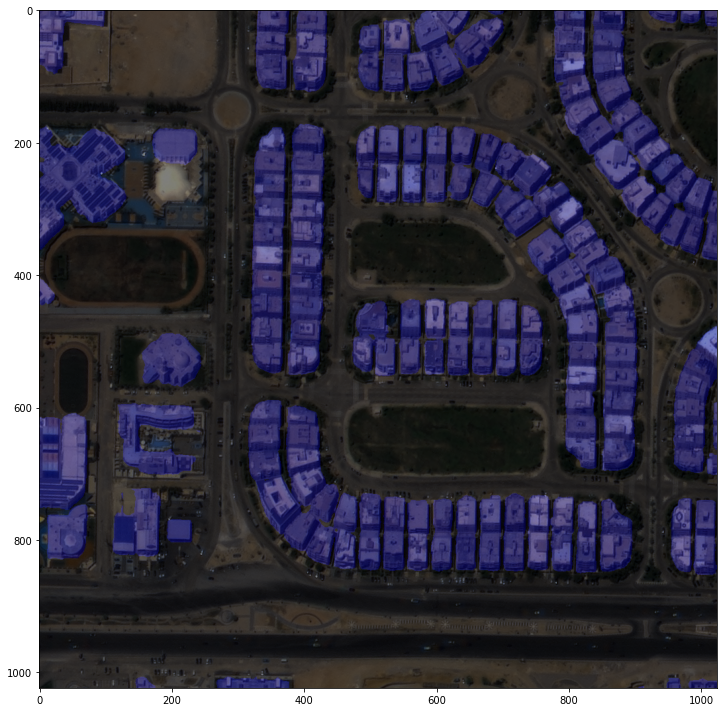

In [16]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


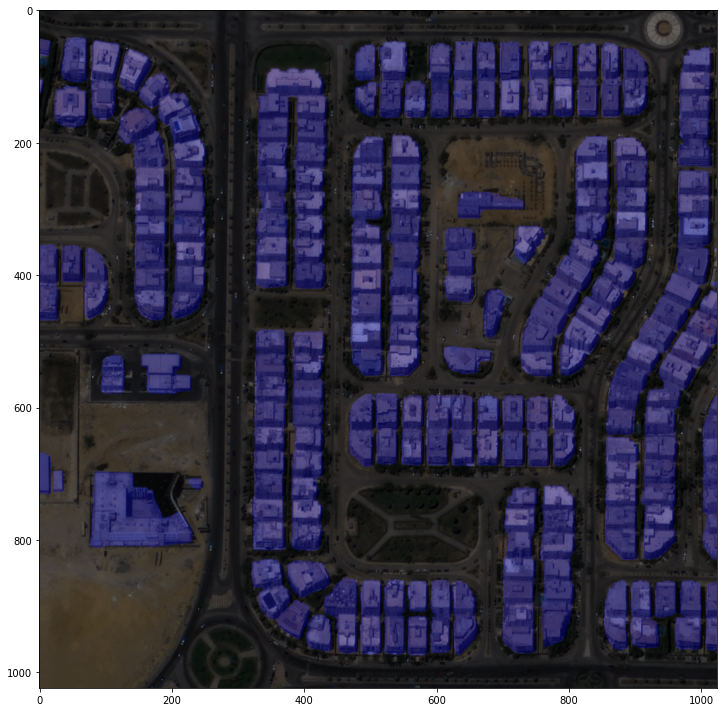

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


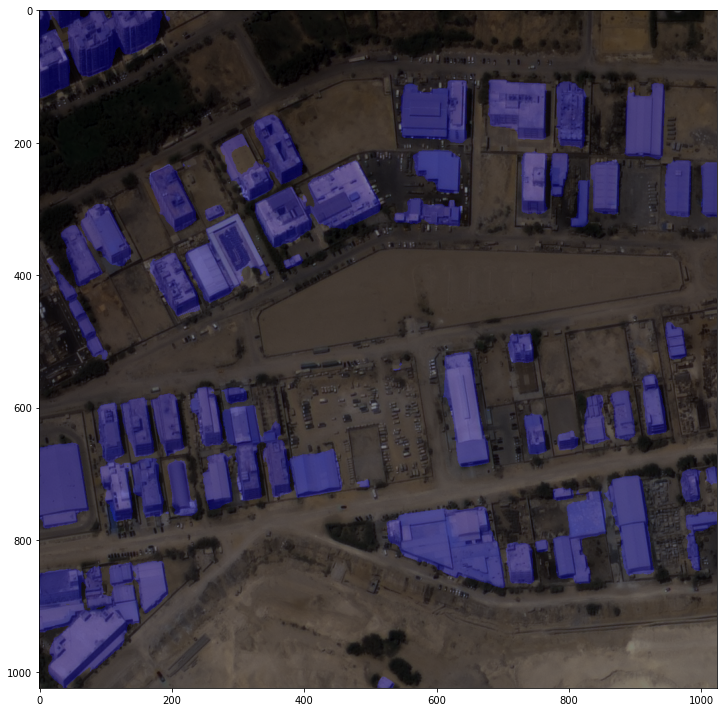

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00697_PS3_K3A_NIA0277.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD04404_PS3_K3A_NIA0378.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


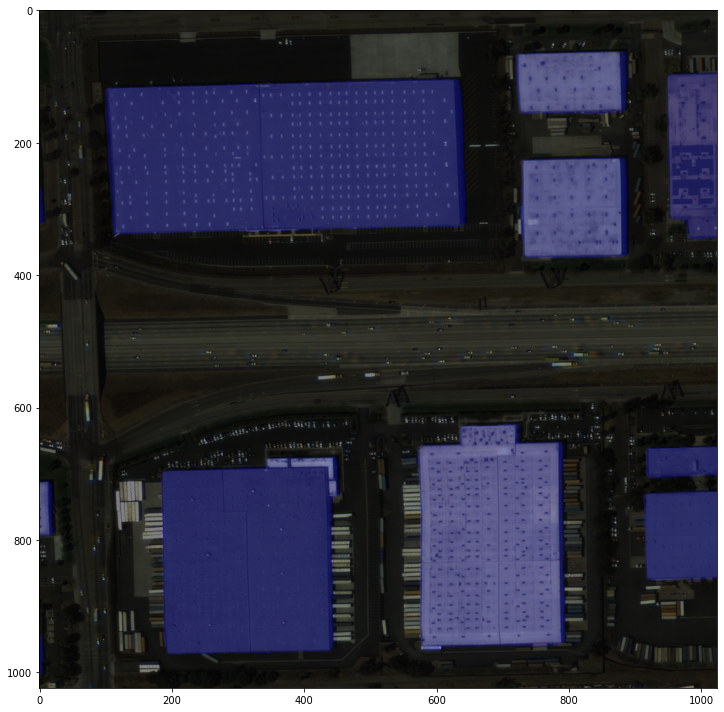

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD10921_PS3_K3A_NIA0389.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ00176_PS3_K3_NIA0081.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ01050_PS3_K3_NIA0089.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ03670_PS3_K3A_NIA0153.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


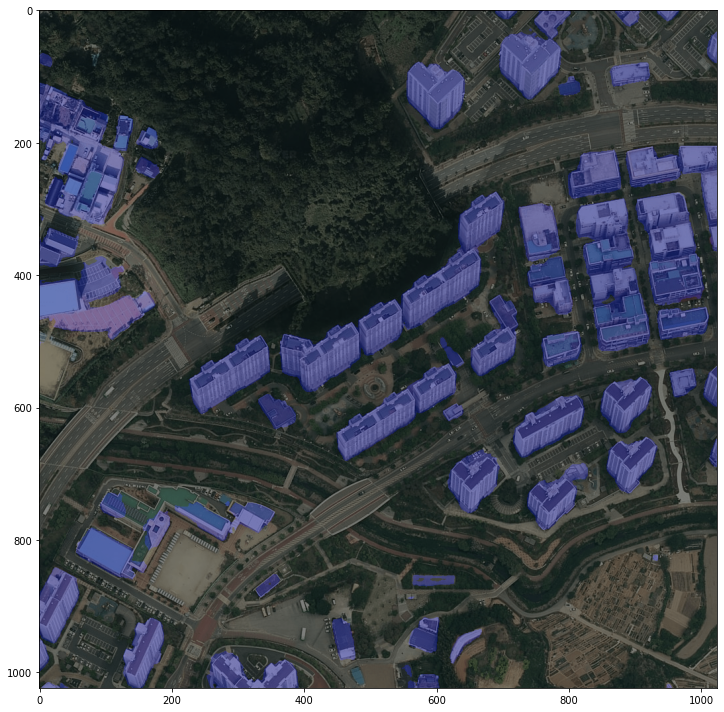

In [26]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


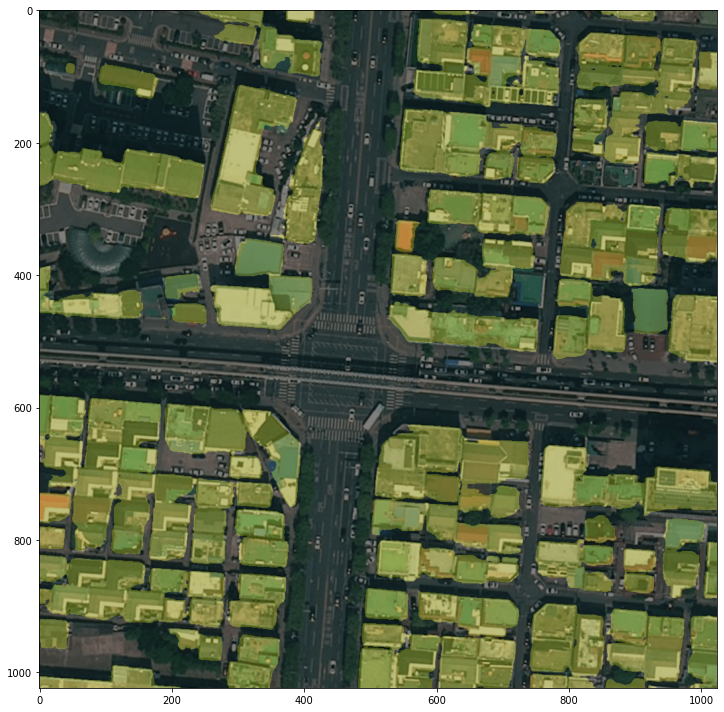

In [29]:
palette_1 = [[0, 0, 0], [128, 128, 0]]
show_result_pyplot(model_ckpt, img, result, palette_1)
